# Helmet Mapping: finding the best NGS positions to keep
Reference: https://www.kaggle.com/its7171/nfl-baseline-simple-helmet-mapping

In [1]:
# # Developer
# %cd /kaggle
# from IPython.display import clear_output
# pat = input('Personal Access Token:')
# clear_output()
# ! git clone https://$pat@github.com/qAp/nfl_helmet_assignment_kaggle.git

In [2]:
# %cd /kaggle/nfl_helmet_assignment_kaggle/
# ! git pull

In [3]:
# User
! cp -r /kaggle/input/nfl-helmet-assignment-kaggle/nfl_helmet_assignment_kaggle /kaggle/.

In [4]:
import os, sys
import importlib
import random
from multiprocessing import Pool
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.append('/kaggle/nfl_helmet_assignment_kaggle/')
from helmet_tracker.utils.features import add_track_features
from helmet_tracker.models.helmet_mapping import *

In [5]:
import helmet_tracker
importlib.reload(helmet_tracker.models.helmet_mapping)

<module 'helmet_tracker.models.helmet_mapping' from '/kaggle/nfl_helmet_assignment_kaggle/helmet_tracker/models/helmet_mapping.py'>

In [6]:
def plt_frame(video, frame, t=None, idxs_discard=None, df_tgt=None):
    
    pth_video = os.path.join(dir_video, video + '.mp4')

    # Get helmets for selected video and frame
    df_helmets = helmets.query('video==@video and frame==@frame')

    # Get NGS players for selected video and frame
    gameKey, playID, view = video.split('_')
    gameKey = int(gameKey)
    playID = int(playID)
    df_ngs = tracking.query('gameKey==@gameKey and playID==@playID')
    nearest_est_frame = find_nearest(df_ngs['est_frame'].values, frame)
    df_ngs = df_ngs.query('est_frame==@nearest_est_frame')

    # Draw a circle around each helmet
    cap = cv2.VideoCapture(pth_video)
    for _ in range(frame):
        read_ok, img = cap.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in df_helmets.itertuples():
        img = cv2.circle(img, 
                         center=(
                             int(box.left + 0.5 * box.width), 
                             int(box.top + 0.5 * box.height)
                         ), 
                         radius=10, color=(255, 255, 255), thickness=5, )
        
    # If helmets are provided with labels
    if df_tgt is not None:
        for box in df_tgt.itertuples():
            img = cv2.putText(img, 
                              text=box.label, 
                              org=(box.left, box.top), 
                              fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                              fontScale=1, 
                              color=(255, 255, 255), 
                              thickness=2)

    # Show helmets and NGS players
    fig, axs = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)
    
    axs[0].imshow(img)
    axs[0].set_title('Camera frame')
    
    # Rotate NGS frame if needed
    if t is not None:
        df_t = rotate_dataframe(df_ngs, t=t)
    else:
        df_t = df_ngs.copy()
        
    for team, d in df_t.groupby('team'):
        x, y = d[['x', 'y']].values.T
        axs[1].scatter(x, y, label=team)
        for x_, y_, label in zip(x, y, d['player'].values):
            axs[1].text(x_, y_, label)

    # Indicate discarded NGS players
    if idxs_discard is not None:        
        df_t = df_t.reset_index(drop=True).copy()
        to_discard = df_t.index.isin(idxs_discard)
        df_discard = df_t[to_discard]
        axs[1].scatter(df_discard['x'].values, df_discard['y'].values,
                       color='black', marker='x', s=100, zorder=6)

    axs[1].set_title(f'NGS frame')
    axs[1].grid(b=True)

    plt.tight_layout();
    
    return fig, axs

In [7]:
def filter_players_minimise_dist_score(xy_hel, xy_ngs, max_iter=1000):
    '''
    # Make number of players equal number of helmets
    # Compute distance score, keeping the minimum
    '''
    
    assert len(xy_ngs) >= len(xy_hel)

    num_discard = len(xy_ngs) - len(xy_hel)

    if num_discard == 0:
        xy = xy_ngs

        xy = xy[xy[:, 0].argsort()]

        xy -= xy.min(axis=0, keepdims=True)
        xy /= xy.max(axis=0, keepdims=True)

        min_dist_score = dist(xy_hel, xy)
        min_idxs_discard = ()

    else:

        min_dist_score = 10_000
        min_idxs_discard = None
        for i in range(max_iter):

            idxs_discard = random.sample(range(len(xy_ngs)), num_discard)
            xy = np.delete(xy_ngs, idxs_discard, axis=0)

            xy = xy[xy[:, 0].argsort()]

            xy -= xy.min(axis=0, keepdims=True)
            xy /= xy.max(axis=0, keepdims=True)

            dist_score = dist(xy_hel, xy)

            if dist_score < min_dist_score:
                min_dist_score = dist_score
                min_idxs_discard = idxs_discard
                
    return min_idxs_discard, min_dist_score

# Setting and loading data

In [8]:
debug = True
BASE_DIR = '/kaggle/input/nfl-health-and-safety-helmet-assignment/'

labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
if debug:
    dir_video = os.path.join(BASE_DIR, 'train')
    tracking = pd.read_csv(f'{BASE_DIR}/train_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/train_baseline_helmets.csv')
else:
    dir_video = os.pth.join(BASE_DIR, 'test')
    tracking = pd.read_csv(f'{BASE_DIR}/test_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/test_baseline_helmets.csv')

In [9]:
%%time

# Add estimated video frame to NGS data

tracking = add_track_features(tracking) 

CPU times: user 1.64 s, sys: 68.6 ms, total: 1.71 s
Wall time: 1.72 s


# Find examples of views from the 4 different sides of the field

In [10]:
%%time
# Extract video, frame and view from 'video_frame' column
video_frame = helmets['video_frame'].str.split('_')
helmets['video'] = video_frame.str[:3].str.join('_')
helmets['frame'] = video_frame.str[3].astype(int)
helmets['view'] =  video_frame.str[2]

CPU times: user 6.28 s, sys: 413 ms, total: 6.7 s
Wall time: 6.7 s


In [11]:
# # Endzone videos
# videos_endzone = helmets[helmets['view']=='Endzone']['video'].unique()

# # Sideline videos
# videos_sideline = helmets[helmets['view']=='Sideline']['video'].unique()

# len(videos_sideline), len(videos_endzone)

In [12]:
# Sample videos. (Manually selected)
# key = rough angle with which NGS frame needs to be rotated 
#       counter-clockwise in order to align with camera frame
# value = video id

sample_videos = {0: '57915_003093_Sideline',
                 270: '57680_002206_Endzone', 
                 180: '58095_004022_Sideline', 
                 90: '57911_002492_Endzone'}

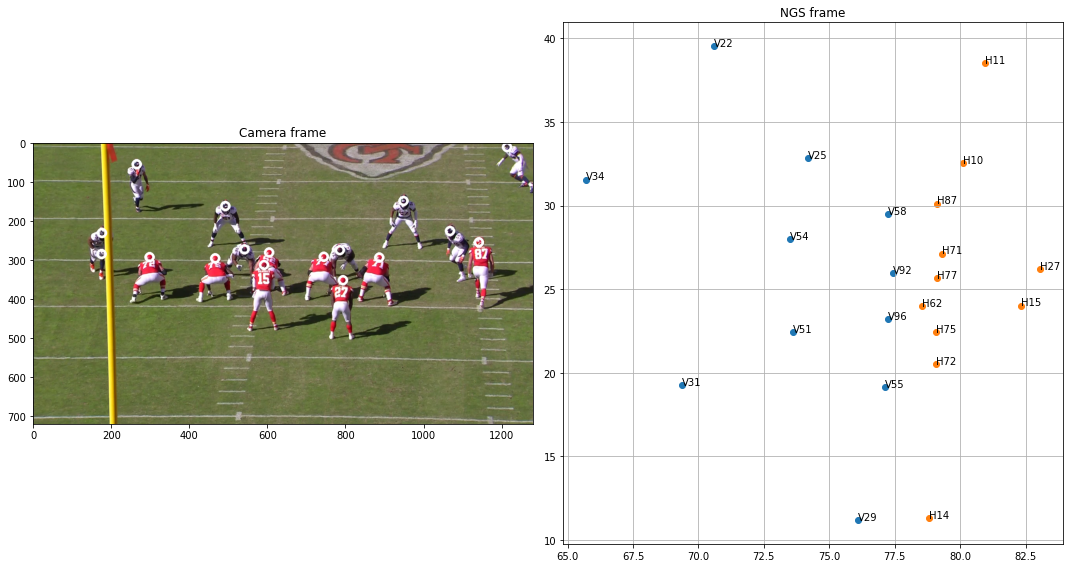

In [13]:
# Show helmets and NGS players

t_init_sample = 270
frame = 5

video = sample_videos[t_init_sample]

fig, axs = plt_frame(video, frame, t=None, idxs_discard=None)

# Rotate NGS frame through range of angles, recording distance scores

In [14]:
t_init_sample = 180
frame = 98
conf_thre = 0.3

In [15]:
video = sample_videos[t_init_sample]
pth_video = os.path.join(dir_video, video + '.mp4')

# Get NGS players for selected video and frame
gameKey, playID, view = video.split('_')
gameKey = int(gameKey)
playID = int(playID)
df_ngs = tracking.query('gameKey==@gameKey and playID==@playID')
nearest_est_frame = find_nearest(df_ngs['est_frame'].values, frame)
df_ngs = df_ngs.query('est_frame==@nearest_est_frame')

# Get helmets for selected video and frame
df_hel = helmets.query('video==@video and frame==@frame')
df_hel = df_hel[df_hel['conf'] > conf_thre].copy()
if len(df_hel) > len(df_ngs):
    df_hel = df_hel.tail(len(df_ngs))

In [16]:
# Get the coordinates of helmet centres
df_hel['helmet_center_x'] = df_hel['left'] + df_hel['width'] / 2
df_hel['helmet_center_y'] = df_hel['top'] + df_hel['height'] / 2
xy_hel = df_hel[['helmet_center_x', 'helmet_center_y']].values

# Flip y-axis to get same right-handedness as NGS reference frame
xy_hel[:, 1] *= -1

# Sort helmets by their x-coordinate, then nornamlise x and y independently
xy_hel = xy_hel[xy_hel[:, 0].argsort()]
xy_hel -= xy_hel.min(axis=0, keepdims=True)
xy_hel /= xy_hel.max(axis=0, keepdims=True)

In [17]:
# Get NGS player centres

xy_ngs = df_ngs[['x', 'y']].values

# Rotate NGS frame by rough alignment angle, `t_init_sample`.

t_init = t_init_sample

xy_ngs = rotate_arr(xy_ngs.T, t_init).T

In [18]:
len(xy_hel), len(xy_ngs)

(19, 22)

In [19]:
# Define which rotation angles to try
tmax = 30
num_t = 20
ts = np.linspace(-tmax, tmax, num_t)
ts

array([-30.        , -26.84210526, -23.68421053, -20.52631579,
       -17.36842105, -14.21052632, -11.05263158,  -7.89473684,
        -4.73684211,  -1.57894737,   1.57894737,   4.73684211,
         7.89473684,  11.05263158,  14.21052632,  17.36842105,
        20.52631579,  23.68421053,  26.84210526,  30.        ])

In [20]:
idxs_discard_list = []
dist_score_list = []
xy_rot_list = []

for t in tqdm(ts, total=len(ts)):
    
    xy_rot = rotate_arr(xy_ngs.T, t).T

    (idxs_discard, 
     dist_score) = filter_players_minimise_dist_score(xy_hel, xy_rot, 
                                                      max_iter=1_000)

    idxs_discard_list.append(idxs_discard)
    dist_score_list.append(dist_score)
    xy_rot_list.append(xy_rot)

  0%|          | 0/20 [00:00<?, ?it/s]

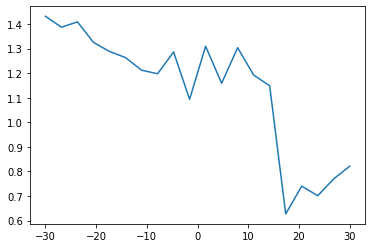

In [21]:
plt.plot(ts, dist_score_list);

In [22]:
idx_min = dist_score_list.index(min(dist_score_list))

t_min = ts[idx_min]
idxs_discard_min = idxs_discard_list[idx_min]
xy_rot_min = xy_rot_list[idx_min]

In [23]:
df_ngs[['x_rot', 'y_rot']] = xy_rot_min
if len(idxs_discard_min) > 0:
    df_ngs.drop(df_ngs.index[idxs_discard_min], axis=0, inplace=True)

df_tgt = df_hel.copy()
df_tgt.sort_values('helmet_center_x', axis=0, inplace=True)
df_tgt['label'] = df_ngs.sort_values('x_rot')['player'].values

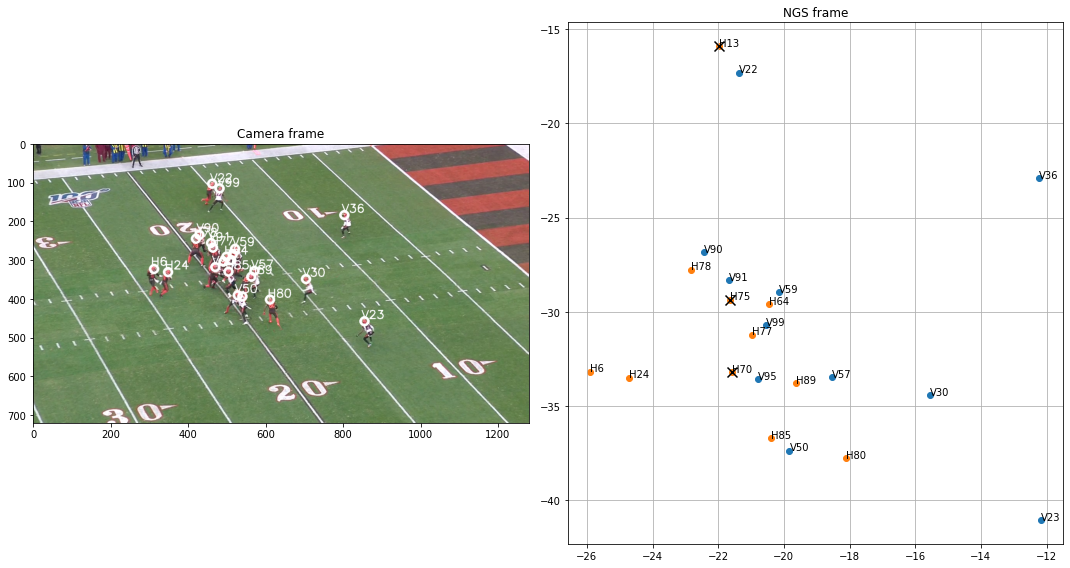

In [24]:
fig, axs = plt_frame(video, frame, 
                     t=t_init + t_min, 
                     idxs_discard=idxs_discard_min, 
                     df_tgt=df_tgt)

# Camera on this side or the opposite side

In practice, whether the camera's on the home or away side is unknown, so for every frame, we need to check the mapping from both sides' viewpoint.  

This means that, for a given view, sideline or endzone, the NGS reference frame will have 2 initial rotational angles, separated by 180 degrees.  After having rotated to each of these, we find the optimal angle of rotation as usual by trying small angle increments around it.

Then, the optimal angle of rotation and discarded player indices correspond to the minimum distance score obtained out of all angles.

In [25]:
t_init_sample = 270
conf_thre = 0.3

In [26]:
video = sample_videos[t_init_sample]
pth_video = os.path.join(dir_video, video + '.mp4')

cap = cv2.VideoCapture(pth_video)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frames = range(1, frame_count + 1, 10)
len(frames)

49

In [27]:
# Define which rotation angles to try
tmax = 40
num_t = 20
ts = np.linspace(-tmax, tmax, num_t)
ts

array([-40.        , -35.78947368, -31.57894737, -27.36842105,
       -23.15789474, -18.94736842, -14.73684211, -10.52631579,
        -6.31578947,  -2.10526316,   2.10526316,   6.31578947,
        10.52631579,  14.73684211,  18.94736842,  23.15789474,
        27.36842105,  31.57894737,  35.78947368,  40.        ])

In [28]:
def score_frames(t_init):
    '''
    Computes the distance scores for frames, after first
    rotating NGS frame by `t_init` degrees.
    '''
    score_list = []

    for frame in tqdm(frames, total=len(frames)):

        # Get NGS players for selected video
        gameKey, playID, view = video.split('_')
        gameKey = int(gameKey)
        playID = int(playID)
        df_ngs = tracking.query('gameKey==@gameKey and playID==@playID')
        nearest_est_frame = find_nearest(df_ngs['est_frame'].values, frame)
        df_ngs = df_ngs.query('est_frame==@nearest_est_frame')

        # Get helmets for selected video and frame
        df_hel = helmets.query('video==@video and frame==@frame')
        df_hel = df_hel[df_hel['conf'] > conf_thre].copy()
        if len(df_hel) > len(df_ngs):
            df_hel = df_hel.tail(len(df_ngs))

        # Get the coordinates of helmet centres
        df_hel['helmet_center_x'] = df_hel['left'] + df_hel['width'] / 2
        df_hel['helmet_center_y'] = df_hel['top'] + df_hel['height'] / 2
        xy_hel = df_hel[['helmet_center_x', 'helmet_center_y']].values

        # Flip y-axis to get same right-handedness as NGS reference frame
        xy_hel[:, 1] *= -1

        # Sort helmets by their x-coordinate, then nornamlise x and y independently
        xy_hel = xy_hel[xy_hel[:, 0].argsort()]
        xy_hel -= xy_hel.min(axis=0, keepdims=True)
        xy_hel /= xy_hel.max(axis=0, keepdims=True)

        # Get NGS player centres
        xy_ngs = df_ngs[['x', 'y']].values.copy()  

        # Rotate NGS frame by rough alignment angle, `t_init_sample`.
        xy_ngs = rotate_arr(xy_ngs.T, t_init).T   

        # Rotate NGS frame incrementally, recording the optimal orientation
        dist_score_min = 10_000
        for t in ts:

            xy_rot = rotate_arr(xy_ngs.T, t).T

            (idxs_discard, 
             dist_score) = filter_players_minimise_dist_score(xy_hel, xy_rot, 
                                                              max_iter=1_000)

            if dist_score < dist_score_min:
                dist_score_min = dist_score

        score_list.append(dist_score_min)

    return np.array(score_list)

In [29]:
scores_p = score_frames(t_init_sample)
scores_m = score_frames(t_init_sample + 180)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

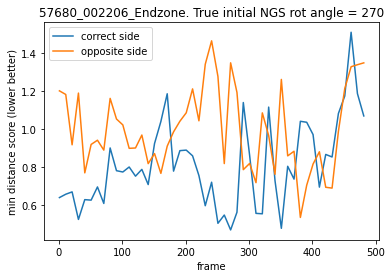

In [30]:
_, ax = plt.subplots()
ax.plot(frames, scores_p, label='correct side')
ax.plot(frames, scores_m, label='opposite side')
ax.set_title(f'{video}. True initial NGS rot angle = {t_init_sample}')
ax.set_ylabel('min distance score (lower better)')
ax.set_xlabel('frame')
ax.legend();

# Package development

Develop `mapping_df_2d`

In [31]:
def _dist_for_different_len_2d(xy_rot, xy_hel, max_iter=1000):
    assert len(xy_rot) >= len(xy_hel)
    num_discard = len(xy_rot) - len(xy_hel)

    if num_discard == 0:
        xy_rot = xy_rot[xy_rot[:, 0].argsort()]
        xy_rot -= xy_rot.min(axis=0, keepdims=True)
        xy_rot /= xy_rot.max(axis=0, keepdims=True)

        min_dist_score = dist(xy_hel, xy_rot)
        min_idxs_discard = ()
        
    else:
        min_dist_score = 10_000
        min_idxs_discard = None
        for _ in range(max_iter):
            idxs_discard = random.sample(range(len(xy_rot)), num_discard)
            xy = np.delete(xy_rot, idxs_discard, axis=0)

            xy = xy[xy[:, 0].argsort()]
            xy -= xy.min(axis=0, keepdims=True)
            xy /= xy.max(axis=0, keepdims=True)
            
            dist_score = dist(xy_hel, xy)

            if dist_score < min_dist_score:
                min_dist_score = dist_score
                min_idxs_discard = idxs_discard
                
    return min_idxs_discard, min_dist_score
            
    
def _dist_rot_2d(df_ngs, xy_hel, t_init=0):
    df_ngs = df_ngs.copy()
    xy_ngs = df_ngs[['x', 'y']].values

    if (t_init % 360) != 0:
        xy_ngs = rotate_arr(xy_ngs.T, t_init).T
        
    tmax = 30
    num_t = 20
    ts = np.linspace(-tmax, tmax, num_t)
    
    min_dist_score = 10_000
    min_idxs_discard = None
    min_xy_rot = None
    for t in ts:
        xy_rot = rotate_arr(xy_ngs.T, t).T
        
        (idxs_discard, 
         dist_score) = _dist_for_different_len_2d(xy_rot, xy_hel)
        
        if dist_score < min_dist_score:
            min_dist_score = dist_score
            min_idxs_discard = idxs_discard
            min_xy_rot = xy_rot

    df_ngs[['x_rot', 'y_rot']] = min_xy_rot
    if len(min_idxs_discard) > 0:
        df_ngs.drop(df_ngs.index[min_idxs_discard], inplace=True)
    players = df_ngs.sort_values('x_rot')['player'].values
    return min_dist_score, players


def _mapping_df_2d(video_frame, df, tracking, conf_thre=0.3):
    gameKey, playID, view, frame = video_frame.split('_')
    gameKey = int(gameKey)
    playID = int(playID)
    frame = int(frame)
    
    df_ngs = tracking.query('gameKey==@gameKey and playID==@playID')
    nearest_est_frame = find_nearest(df_ngs['est_frame'].values, frame)
    df_ngs = df_ngs.query('est_frame==@nearest_est_frame')
    
    # Get helmets for selected video and frame
    df_hel = df.query('video==@video and frame==@frame')
    df_hel = df_hel[df_hel['conf'] > conf_thre].copy()
    if len(df_hel) > len(df_ngs):
        df_hel = df_hel.tail(len(df_ngs)) 

    # Helmet centres
    df_hel['helmet_center_x'] = (df_hel['left'] + df_hel['width'] / 2)
    df_hel['helmet_center_y'] = (df_hel['top'] + df_hel['height'] / 2)
    
    # Sort helmets by their x-coordinate
    df_hel.sort_values('helmet_center_x', inplace=True)
    
    # Helmets' (x, y) coordinates
    xy_hel = df_hel[['helmet_center_x', 'helmet_center_y']].values
    xy_hel[:,1] *= -1 # Flip y-axis to get same right-handedness as NGS reference frame
    xy_hel -= xy_hel.min(axis=0, keepdims=True)
    xy_hel /= xy_hel.max(axis=0, keepdims=True)    
    
    t_init = 0 if view == 'Sideline' else 90
    
    dist_p, players_p = _dist_rot_2d(df_ngs, xy_hel, t_init)
    dist_m, players_m = _dist_rot_2d(df_ngs, xy_hel, t_init + 180)    
    
    if dist_p < dist_m:
        min_dist = dist_p
        min_players = players_p
    else:
        min_dist = dist_m
        min_players = players_m    
        
    df_tgt = df_hel.copy()
    df_tgt['label'] = min_players
    return df_tgt[['video_frame', 'left', 'width', 'top', 'height', 'label']]


In [32]:
t_init_sample = 90
frame = 1
conf_thre = 0.3

In [33]:
%%time

video = sample_videos[t_init_sample]
video_frame = f'{video}_{frame}'

df = helmets.query('video==@video and frame==@frame')

df_tgt = _mapping_df_2d(video_frame, df, tracking, conf_thre)

CPU times: user 2.6 s, sys: 969 µs, total: 2.6 s
Wall time: 2.6 s


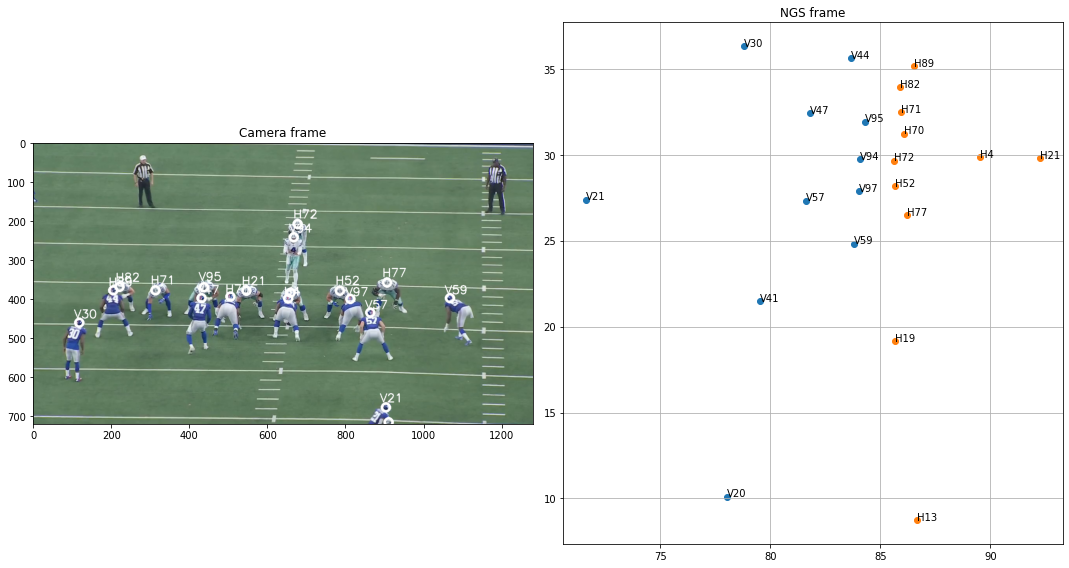

In [34]:
fig, axs = plt_frame(video, frame, df_tgt=df_tgt)

In [35]:
df_tgt

,video_frame,left,width,top,height,label
160768,57911_002492_Endzone_1,105,27,448,25,V30
160762,57911_002492_Endzone_1,193,24,366,22,H89
160754,57911_002492_Endzone_1,211,21,354,28,H82
160759,57911_002492_Endzone_1,301,24,361,32,H71
160756,57911_002492_Endzone_1,419,25,386,23,V47
160757,57911_002492_Endzone_1,424,26,352,34,V95
160755,57911_002492_Endzone_1,492,26,384,18,H70
160760,57911_002492_Endzone_1,534,24,363,31,H21
160752,57911_002492_Endzone_1,642,22,390,16,H4
160765,57911_002492_Endzone_1,656,22,228,27,V94
